In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import jax
from jax import jit
from jax.lib import xla_bridge
print(f"Jax is using: {xla_bridge.get_backend().platform}")

Jax is using: gpu


# Simulate data

In [32]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4 # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch # length of the transducer [m]
transducer_frequency = 1e6 # frequency of the transducer [Hz]
transducer_magnitude = 1e6 # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


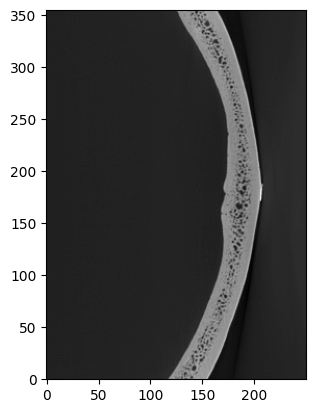

In [37]:
import pydicom

# define skull slice
skull_dicom = pydicom.dcmread("../data/skull_slice.dcm")
skull_array = skull_dicom.pixel_array.astype(np.int16)
skull_array = skull_array[:500, 500:-500]
skull_array = np.flipud(skull_array)
downsampling_factor = 2
new_shape = (skull_array.shape[0] // downsampling_factor, skull_array.shape[1] // downsampling_factor)
skull_array = jax.image.resize(skull_array, new_shape, method='nearest').T
plt.imshow(skull_array, cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [38]:
# define spatial parameters
N = np.array(skull_array.shape).astype(int) # grid size [grid points]
dx = np.array([9.07935931401377e-5*downsampling_factor, 9.07935931401377e-5*downsampling_factor]) # grid spacing [m]
pml = np.array([20, 20]) # size of the perfectly matched layer [grid points]

In [47]:
# define transducer position in domain
transducer_depth = pml[1] # depth of the transducer [grid points]
transducer_x_start = N[0]//2 - (nelements//2 * element_pitch // dx[1]) # start index of the transducer in the x-direction [grid points]
element_positions = np.array([
    np.linspace(transducer_x_start, transducer_x_start + (nelements - 1) * element_pitch // dx[1], nelements),
    (N[1] - transducer_depth) * np.ones(nelements),
], dtype=int)
element_positions

array([[127, 128, 130, 131, 133, 135, 136, 138, 139, 141, 143, 144, 146,
        148, 149, 151, 152, 154, 156, 157, 159, 161, 162, 164, 165, 167,
        169, 170, 172, 173, 175, 177, 178, 180, 182, 183, 185, 186, 188,
        190, 191, 193, 195, 196, 198, 199, 201, 203, 204, 206, 207, 209,
        211, 212, 214, 216, 217, 219, 220, 222, 224, 225, 227, 229],
       [230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230,
        230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230, 230]])

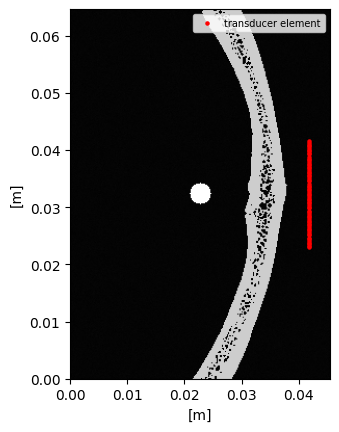

In [67]:
from jwave_utils import get_domain, get_homogeneous_medium, get_skull_medium

# define jwave medium
domain = get_domain(N, dx)
medium_homogenous = get_homogeneous_medium(domain, background_std=0, background_seed=29)

scatterer_positions = np.array([[domain.N[0]//2, domain.N[1]//2]], dtype=int)
medium = get_skull_medium(domain, skull_array, scatterer_positions=scatterer_positions, 
                                background_std = 0.004, scatterer_radius=10, scatterer_contrast=2, 
                                background_seed=28)

ext = [0, N[1]*dx[1], N[0]*dx[0], 0]
plt.scatter(element_positions[1]*dx[1], element_positions[0]*dx[0],
            c='r', marker='o', s=5, label='transducer element')
plt.imshow(medium.sound_speed.params, cmap='gray', extent=ext)
# plt.colorbar(label='Speed of sound [m/s]')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.legend(prop={'size': 7})
plt.gca().invert_yaxis()
plt.show()

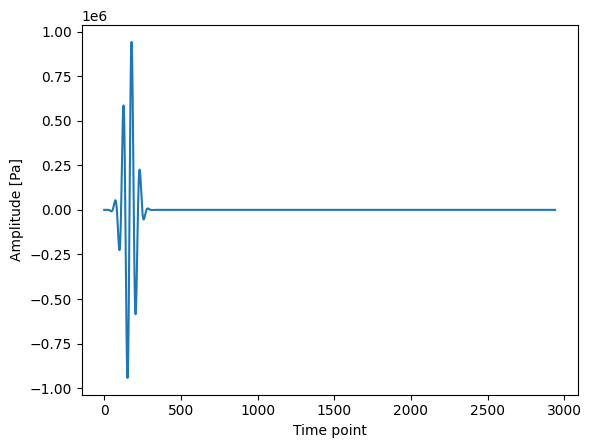

In [68]:
from jwave.geometry import TimeAxis
from jwave_utils import get_plane_wave_excitation

signal_delay = 0
time_axis = TimeAxis.from_medium(medium, cfl=0.3)
# sources = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions)
sources, signal, carrier_signal = get_plane_wave_excitation(domain, time_axis, transducer_magnitude, transducer_frequency, element_positions, signal_delay=signal_delay)


plt.plot(sources.signals[0])
plt.xlabel('Time point')
plt.ylabel('Amplitude [Pa]')
plt.show()

In [69]:
from jwave_utils import get_data

# simulate data using jwave
pressure, data = get_data(medium, time_axis, sources, element_positions)
_, data_homogenous = get_data(medium_homogenous, time_axis, sources, element_positions)

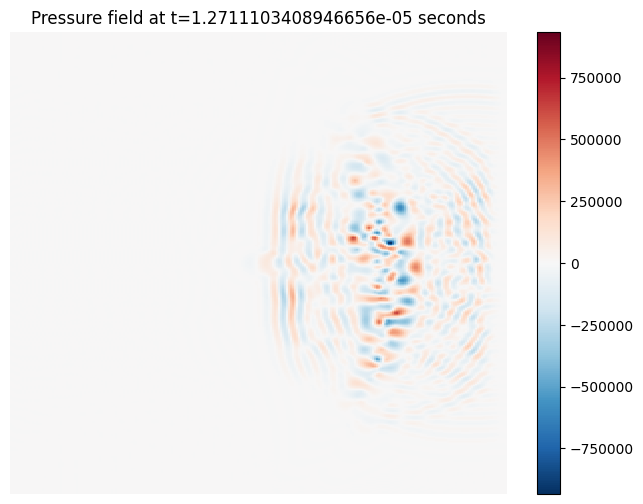

In [70]:
from jwave.utils import show_field

t_idx = 700
show_field(pressure[t_idx])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

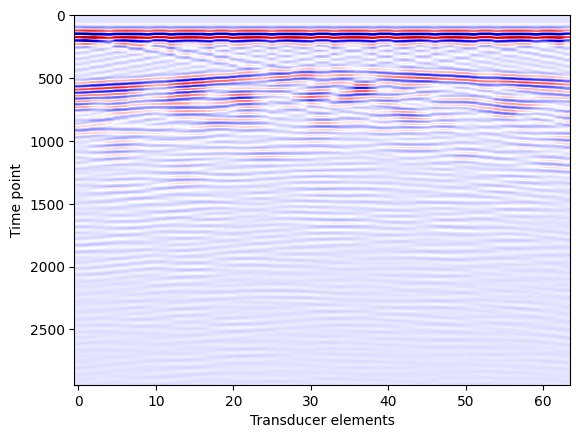

In [71]:
plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

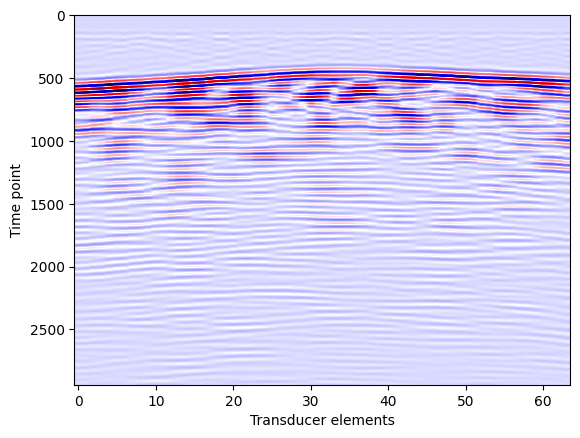

In [72]:
output_data = data-data_homogenous
plt.imshow(output_data, aspect='auto', cmap='seismic')
plt.xlabel('Transducer elements')
plt.ylabel('Time point')
plt.show()

# Reconstruction

## Single angle

In [73]:
from beamforming_utils import get_receive_beamforming
res = get_receive_beamforming(domain, time_axis, element_positions, output_data, signal, carrier_signal, signal_delay)

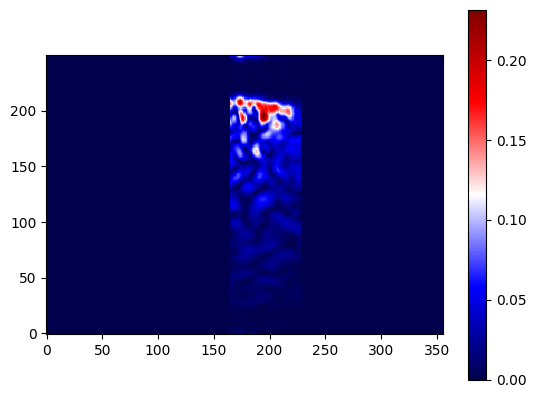

In [74]:
from kwave.utils.filters import gaussian_filter
from kwave.reconstruction.beamform import envelope_detection

def postprocess_result(orig_res):
    result = np.copy(orig_res)
    for i in range(result.shape[0]):
        result[i, :] = gaussian_filter(result[i, :], 1/dx[0], transducer_frequency, 100.0)
    for i in range(result.shape[0]):
        result[i, :] = envelope_detection(result[i, :])
    return np.flipud(result).T

bmode=postprocess_result(res)
plt.imshow(bmode, cmap='seismic', interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()